### XGBoost Regressor

In [1]:
# Import basic modules
import math
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

%matplotlib inline 

def read_owm_data(fn):
    data = pd.read_csv(fn)
    data = data.rename(columns=lambda x: x.strip())  
    
    dates = (data['timestamp']//1000).apply(lambda x: datetime.fromtimestamp(x))
    data.insert(loc=0, column='Dates', value=dates)
    data = data.set_index('Dates')
    data = data.rename(columns={"pwr": "SDGE"})

    time_rs = (data['timestamp'] - data['sunrise']) / (data['sunset'] - data['sunrise'])
    data.insert(loc=len(data.columns)-1, column='time_rs', value=time_rs)

    sdge = data.drop(['timestamp','sunrise','sunset'], axis=1) 
    sdge_lin = pd.get_dummies(sdge)
    
    return sdge_lin, ['temp', 'humidity', 'rain', 'cloud', 'visibility','time_rs']

def train_test(data, test_size = 0.15, test_num = -1, scale = False, cols_to_transform=None):
    df = data.copy()
    
    # get the index after which test set starts
    if test_num == -1:
        test_index = int(len(df)*(1-test_size))
    else:
        test_index = len(df) - test_num
    
    # StandardScaler fit on the entire dataset
    if scale:
        scaler = StandardScaler()
        df[cols_to_transform] = scaler.fit_transform(df[cols_to_transform])
        
    X_train = df.drop('SDGE', axis = 1).iloc[:test_index]
    y_train = df.SDGE.iloc[:test_index]
    X_test = df.drop('SDGE', axis = 1).iloc[test_index:]
    y_test = df.SDGE.iloc[test_index:]    
    
    return X_train, X_test, y_train, y_test

def train_test_rand(data, test_size = 0.15, scale = False, cols_to_transform=None):
    df = data.copy()
    
    # StandardScaler fit on the entire dataset
    if scale:
        scaler = StandardScaler()
        df[cols_to_transform] = scaler.fit_transform(df[cols_to_transform])
        
    data_X = df.drop('SDGE', axis = 1)
    data_Y = df.SDGE
    X_train0, X_test0, y_train0, y_test0 = train_test_split(data_X, data_Y, test_size=test_size, random_state=7)
    
    X_train = X_train0.copy(deep=True)
    X_test = X_test0.copy(deep=True)
    y_train = y_train0.copy(deep=True)
    y_test = y_test0.copy(deep=True)    
    
    return X_train, X_test, y_train, y_test

def error_metrics(y_pred, y_truth, model_name = None):
    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()
        
    if isinstance(y_truth, np.ndarray):
        y_truth = y_truth
    else:
        y_truth = y_truth.to_numpy()
        
    print('\nError metrics for model {}'.format(model_name))
    
    RMSE = np.sqrt(mean_squared_error(y_truth, y_pred))
    print("RMSE or Root mean squared error: %.2f" % RMSE)  

    MAE = mean_absolute_error(y_truth, y_pred)
    print('Mean Absolute Error: %.2f' % MAE)
    
    # Explained variance score: 1 is perfect prediction
    R2 = r2_score(y_truth, y_pred)
    print('Variance score: %.2f' % R2 )
    
    name_error = ['model', 'RMSE', 'MAE', 'R2']
    value_error = [model_name, RMSE, MAE, R2]
    list_error = list(zip(name_error, value_error))
    
    # Creating an empty dict to save all the erros from different models
    dict_error = dict()
    
    for error in list_error:
        dict_error[error[0]] = error[1]
        
    return(dict_error)

In [2]:
sdge_lin,cols_to_transform = read_owm_data('all_owm.csv')
X_train, X_test, y_train, y_test = train_test_rand(sdge_lin, test_size = 0.3, scale = False, cols_to_transform=cols_to_transform)

#### XGBoost without lag data

In [3]:
import xgboost as xgb

In [47]:
regr = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3,
    learning_rate=0.2
)
regr.fit(X_train, y_train)

y_hat = regr.predict(X_train)
error_metrics(y_hat, y_train, 'Training data')

y_hat = regr.predict(X_test)
error_metrics(y_hat, y_test, 'Test data')


Error metrics for model Training data
RMSE or Root mean squared error: 14.23
Mean Absolute Error: 8.54
Variance score: 0.89

Error metrics for model Test data
RMSE or Root mean squared error: 15.08
Mean Absolute Error: 9.15
Variance score: 0.88


{'model': 'Test data',
 'RMSE': 15.076293782954552,
 'MAE': 9.145081059094831,
 'R2': 0.8768323791244249}

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

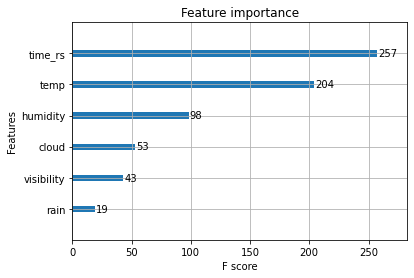

In [13]:
xgb.plot_importance(regr)

#### XGBoost with lag data

In [49]:
lag_day = 2

# Creating the lag variables
for i in range(24):
    sdge_lin['lag'+str(i+1)] = sdge_lin['SDGE'].shift(lag_day * 24 + i + 1)
    
lag_sdge = sdge_lin.dropna()
X_train, X_test, y_train, y_test = train_test_rand(lag_sdge, test_size = 0.3, scale = False, cols_to_transform=cols_to_transform)

In [74]:
regr = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=2.0,
    gamma=0.9,
    max_depth=6,
    learning_rate=0.05
)
regr.fit(X_train, y_train)

y_hat = regr.predict(X_train)
error_metrics(y_hat, y_train, 'Training data')

y_hat = regr.predict(X_test)
error_metrics(y_hat, y_test, 'Test data')


Error metrics for model Training data
RMSE or Root mean squared error: 8.67
Mean Absolute Error: 4.46
Variance score: 0.96

Error metrics for model Test data
RMSE or Root mean squared error: 14.48
Mean Absolute Error: 7.26
Variance score: 0.89


{'model': 'Test data',
 'RMSE': 14.484635137506862,
 'MAE': 7.261116265342561,
 'R2': 0.8919670542194466}

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

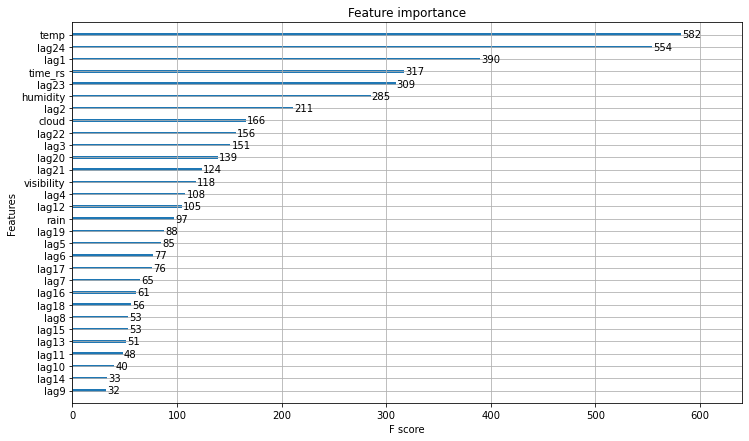

In [77]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(regr)